# Example3.1-DSSD Energy Calibration

## Goals

- 能量刻度方法；
- TSpectrum的基本用法（扣本地、寻峰、记录峰位与计数）；
- vector，map的基本用法（排序）；
- TH1，Graph Fit;

**数据**：s4.root

```c++
Int_t pe[48];//Pie 0-47
Int_t re[48];//Ring 0-47
```

**基本步骤**
- 1 将ADC的谱进行连续化。(下面示例中没有做这一步)；
- 2 寻峰得到的alhpa峰位与已知alpha能量之间进行匹配(利用TSpectrum)，利用峰位估计值进行粗刻度；
- 3 选取合理的拟合区间，对每个峰进行高斯拟合，得到最终刻度系数；

## 查谱，刻度

### 打开s4.root文件

In [1]:
//%jsroot on
TFile *f=new TFile("../s4.root");
TTree *tree=(TTree*)f->Get("tree");
TCanvas *c1=new TCanvas;

### 查谱

- 查看pe相邻条能谱；

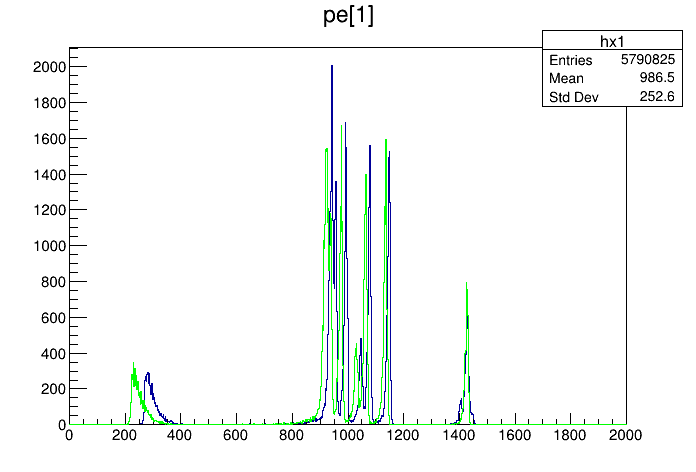

In [2]:
tree->Draw("pe[0]>>hx0(1000,0,2000)");//单条
tree->Draw("pe[1]>>hx1(1000,0,2000)");//单条
TH1I *hx0=(TH1I*)gROOT->FindObject("hx0");
TH1I *hx1=(TH1I*)gROOT->FindObject("hx1");
hx0->SetLineColor(kGreen);
hx1->Draw();
hx0->Draw("same");
c1->Draw();

- 查看pe所有条（48路）能谱

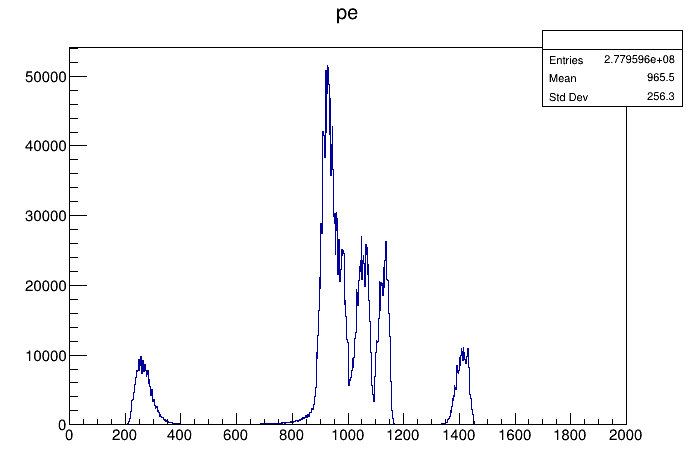

In [3]:
tree->Draw("pe>>(1000,0,2000)");//所有条pe[0-47]
c1->Draw();

- 查看re相邻条能谱；

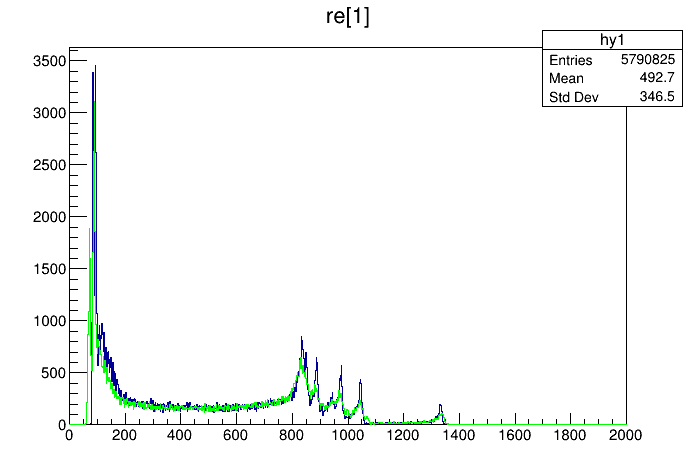

In [4]:
tree->Draw("re[0]>>hy0(1000,0,2000)");//单条
tree->Draw("re[1]>>hy1(1000,0,2000)");//单条
TH1I *hy0=(TH1I*)gROOT->FindObject("hy0");
TH1I *hy1=(TH1I*)gROOT->FindObject("hy1");
//gPad->SetLogy();
hy0->SetLineColor(kGreen);
hy1->Draw();
hy0->Draw("same");
c1->Draw();

### peaks.C--利用TSpectrum寻找histogram中的峰位，并进行标注。

```c++
TH1F *h=NULL,*hb=NULL;
Int_t nfound;
Double_t *xpeaks=NULL, *ypeaks=NULL;
TSpectrum *s=NULL;
void peaks(TString hname, vector<Double_t> &pe, Double_t thres=0.05,int backsub=0)
{
    pe.clear();//清空pe
    multimap<Int_t,Double_t> me;//用于排序
    h=(TH1F*)gROOT->FindObject(hname);
    if(!s)    s=new TSpectrum(500);
    
    if(backsub)
    {
        hb=(TH1F*)s->Background(h,80,"same");//80-本底光滑程度
        h->Add(h,hb,1,-1);   
    }
    
    nfound=s->Search(h,2,"",thres); 
    
    TList *functions = h->GetListOfFunctions();//added by xi
    TPolyMarker *pm=(TPolyMarker *)h->GetListOfFunctions()->FindObject("TPolyMarker");
    pm->SetMarkerStyle(32);
    pm->SetMarkerColor(kGreen);
    pm->SetMarkerSize(0.4);
    xpeaks=s->GetPositionX();
    ypeaks=s->GetPositionY();
    
    TString sout;
    for(int j=0;j<nfound;j++) 
    {
        stringstream ss;
        ss<<xpeaks[j];
        TString s1=ss.str();
        TLatex *tex=new TLatex(xpeaks[j],ypeaks[j],s1);
        //sout.Form("%2d. %4d %d",j,xpeaks[j],ypeaks[j]);
        //cout<<sout.Data()<<endl;
        me.insert(make_pair(int(ypeaks[j]),xpeaks[j]));
        tex->SetTextFont(13);
        tex->SetTextSize(14);
        tex->SetTextAlign(12);
        tex->SetTextAngle(90);
        tex->SetTextColor(kRed);
        tex->Draw();
    }
    
    for(auto ie=me.rbegin(); ie!=me.rend(); ie++) 
    {
        cout<<ie->second<<" "<<ie->first<<endl;//peak,count;
        pe.push_back(ie->second);//按照计数由大到小填入
    }
  me.clear();
}
```

### 调用peacks.C程序

**注意调用前，相关参量的声明**

In [5]:
gROOT->ProcessLine(".L ./peaks.C");//可以在代码内部直接使用，等价于.L peaks.C
vector<Double_t> pe;
Double_t e[4]={5.5658,6.1748, 6.6708, 8.6931};//alpha energy

### 用peaks程序寻峰

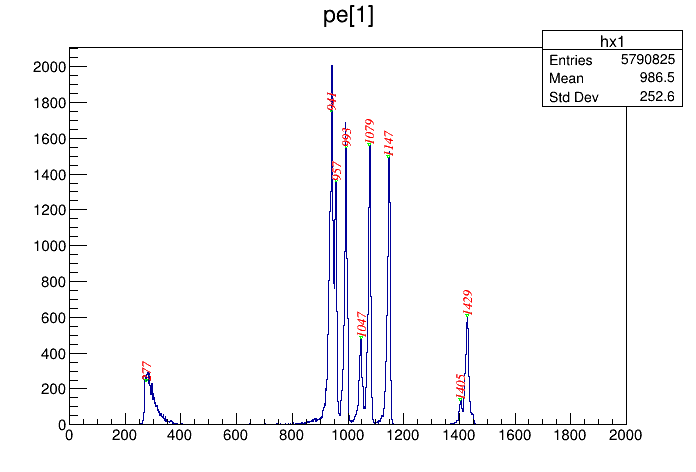

Num of Peaks:  1  x:     941  y:    1751
Num of Peaks:  2  x:    1079  y:    1559
Num of Peaks:  3  x:     993  y:    1550
Num of Peaks:  4  x:    1147  y:    1494
Num of Peaks:  5  x:     957  y:    1359
Num of Peaks:  6  x:    1429  y:     604
Num of Peaks:  7  x:    1047  y:     480
Num of Peaks:  8  x:     277  y:     239
Num of Peaks:  9  x:    1405  y:     133


In [6]:
peaks("hx1",pe);
gPad->SetLogy(0);
c1->Draw();

**PS：peaks中的map是按照统计排序的，并按照统计由多到少，将对应的xch填入向量pe中**

### 匹配策略
- 观察能谱可知：
  - 993，1079，1147,1429为与已知alpha能量匹配的峰位。
  - 上面四个峰的高度相差不多，因此不能根据高度完全确定它们之间的前后顺序(TSpectrum寻出的峰位有时候不一定落在最高处)。
  - 如果某一路分辨差时，941和957可能并称一个峰。
- 根据上述特征，确定峰位-alpha能量匹配策略为：
  - 选择前6个峰，按照能量由大到小排序，然后取前4个峰进行匹配。
  - 匹配后用拟合的chi2/ndf进行检验。
- 根据实际情况可以有不同的策略。 

**更一般的策略为，将TSpectrum寻到的峰位与刻度能量进行随机组合,对比拟合后的chi2/ndf值**

### 选择上述统计最高的六个峰，再对能量排序，取能量最大的四个峰匹配

In [7]:
sort(pe.begin(),pe.begin()+6); //pe按照统计由高到底，存入了对应统计的峰位（能量），sort：按照能量排序
Double_t mpe[4],cpe[4];//peak,count
for(int i=0;i<4;i++) {
    mpe[i]=pe[2+i]; //取能量最高的四个峰
    cpe[i]=hx1->GetBinContent(hx1->FindBin(mpe[i]));
    cout<<mpe[i]<<" "<<cpe[i]<<endl;
}

993 1550
1079 1559
1147 1494
1429 604


### 确认峰的匹配是否正确

- 拟合能量 vs 峰位

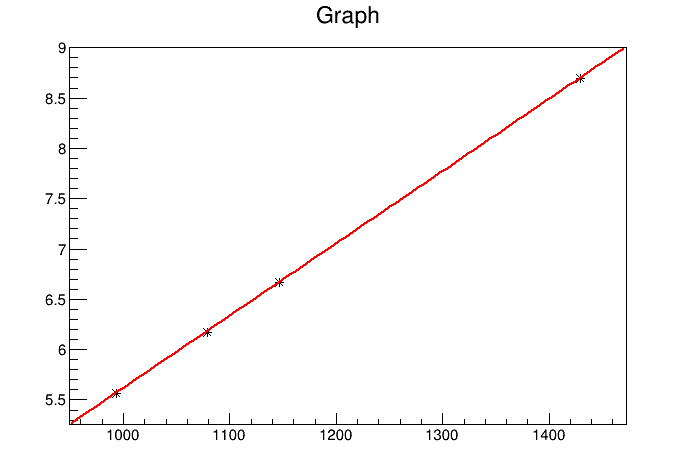


****************************************
Minimizer is Linear
Chi2                      =  4.40562e-05
NDf                       =            2
p0                        =     -1.56557   +/-   0.0168397   
p1                        =   0.00717874   +/-   1.43506e-05 


In [8]:
TGraph *gr=new TGraph(4,mpe,e);
gr->Draw("A*");
gr->Fit("pol1");
TF1 *f1=gr->GetFunction("pol1");
c1->Draw();

- 查看偏差

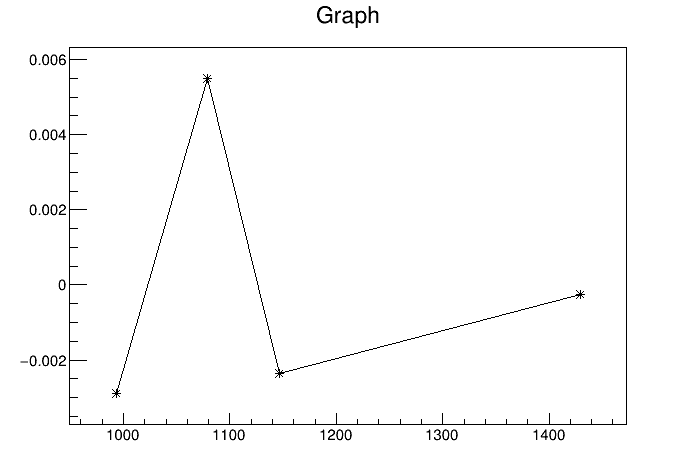

In [9]:
Double_t p0=f1->GetParameter(0);
Double_t p1=f1->GetParameter(1);
Double_t dpe[4];

for(int i=0;i<4;i++) dpe[i]=p0+p1*mpe[i]-e[i];

TGraph *rgr=new TGraph(4,mpe,dpe);
rgr->Draw("AL*");
c1->Draw();

### 确定拟合区间，进行高斯拟合

- 设定合理的拟合初值，进行拟合
  - 峰位，峰高用前面得到的数据，半高宽直接目测估计。
- alpha峰位低能部分不对称，拟合区域偏向峰位高能部分

**查看$\sigma$与拟合区间**

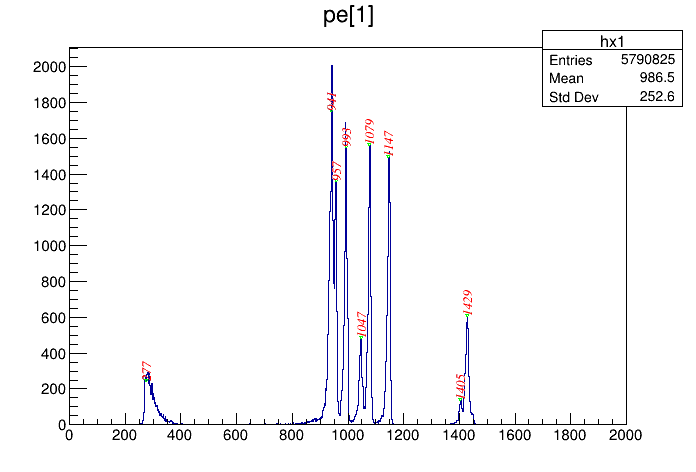

In [10]:
hx1->Draw();
c1->Draw();

**利用peak得到的峰位（mean）与计数（Conunts）作为拟合的初始参量**

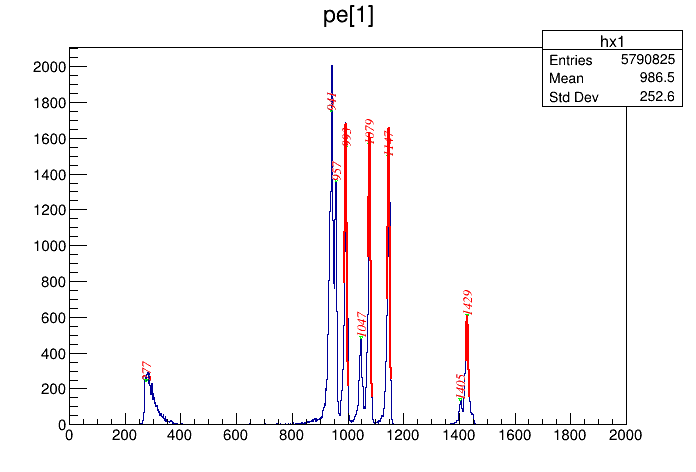

peaks= 993, sigma=3.98, chi2/ndf=12.91
peaks=1078, sigma=4.00, chi2/ndf=11.31
peaks=1147, sigma=3.98, chi2/ndf=13.35
peaks=1429, sigma=4.83, chi2/ndf=1.27


In [11]:
double par[4][3];//peak,sigma,chi2/ndf
double ge[4];
TF1 *fg[4];
TFitResultPtr fr;
for(int i=0;i<4;i++) {
    fg[i]=new TF1(Form("fg%d",i),"gaus");
    fg[i]->SetParameters(cpe[i],mpe[i],4);//constant,mean, sigma，将寻峰的结果作为第二次拟合的初始参量；
    fr=hx1->Fit(fg[i],"SQ+","",mpe[i]-5,mpe[i]+8);//superimpose TF1 to hx1，区间不对称拟合，低能少，高能多
    par[i][0]=fg[i]->GetParameter(1);
    par[i][1]=fg[i]->GetParameter(2);
    par[i][2]=fr->Chi2()/fr->Ndf();
    ge[i]=par[i][0];//得到新的峰位拟合结果
    cout<<Form("peaks=%4.f, sigma=%.2f, chi2/ndf=%.2f",par[i][0],par[i][1],par[i][2])<<endl;
}
c1->Draw();

### 正式刻度，并查看能量vs峰位

**拟合、刻度**

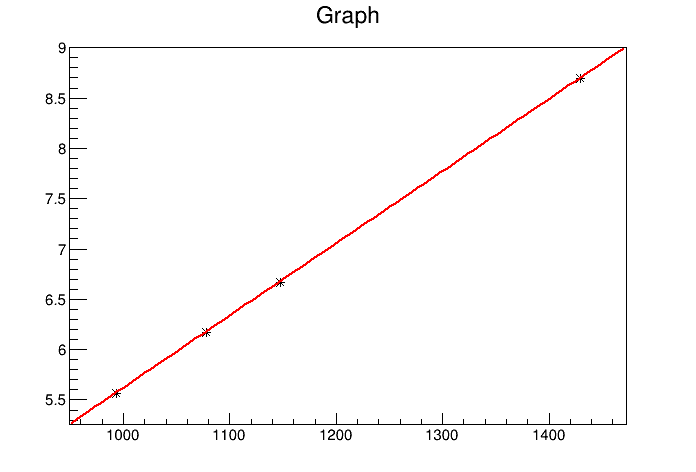


****************************************
Minimizer is Linear
Chi2                      =  5.94348e-06
NDf                       =            2
p0                        =     -1.55862   +/-   0.00618008  
p1                        =   0.00717354   +/-   5.26708e-06 


In [12]:
TGraph *gr1=new TGraph(4,ge,e);
gr1->Draw("A*");
gr1->Fit("pol1");
TF1 *f2=gr->GetFunction("pol1");
c1->Draw();

**查看偏差**

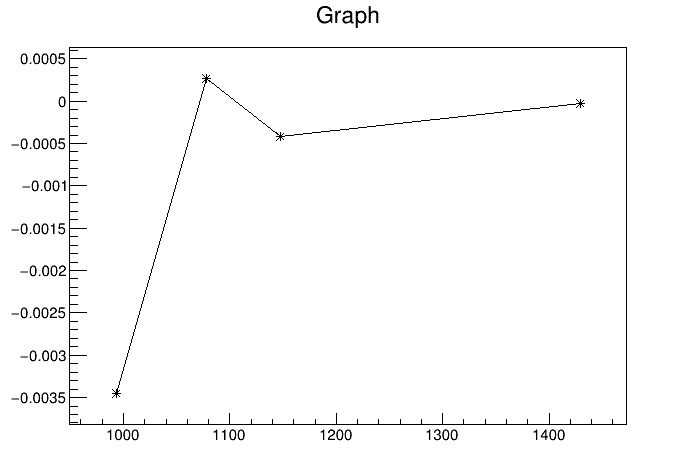

In [13]:
p0=f2->GetParameter(0);
p1=f1->GetParameter(1);
for(int i=0;i<4;i++) dpe[i]=p0+p1*ge[i]-e[i];
TGraph *rgr1=new TGraph(4,ge,dpe);
rgr1->Draw("AL*");
c1->Draw();

### 查看刻度后能谱

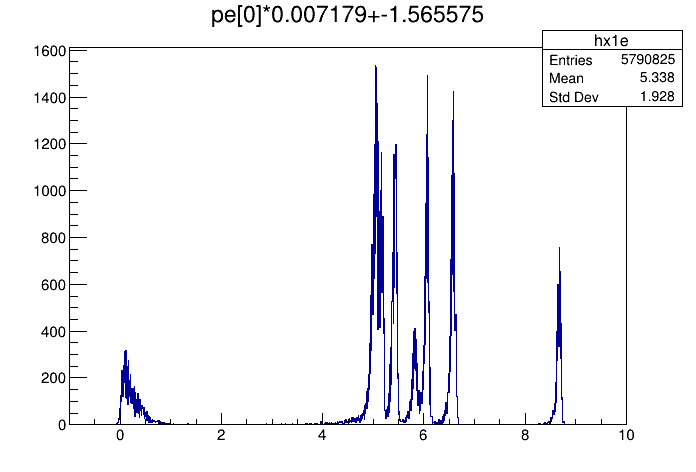

In [14]:
tree->Draw(Form("pe[0]*%f+%f>>hx1e(1000,-1,10)",p1,p0));//单条
hx1e->Draw();
c1->Draw();//存在锯齿，需要在刻度前加入dithering。

In [15]:
!jupyter nbconvert example3_1.ipynb --to html

[NbConvertApp] Converting notebook example3_1.ipynb to html


